In [1]:
# Configuración de GPU
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

import mlflow
import dagshub

import json
import gc
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow: {tf.__version__}")
print(f"Optuna: {optuna.__version__}")

/home/enriq/tf-gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow: 2.20.0
Optuna: 4.6.0


In [4]:
# Verificar GPU
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs disponibles: {len(gpus)}")

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU configurada correctamente: {gpus[0].name}")
    except RuntimeError as e:
        print(f"Error al configurar GPU: {e}")
else:
    print("No se detectó GPU, usando CPU")

GPUs disponibles: 1
GPU configurada correctamente: /physical_device:GPU:0


In [5]:
# DagsHub
dagshub.init(repo_owner='404brainnotfound-ai', repo_name='Tarea_6', mlflow=True)
mlflow.set_experiment("Plant_Pathology_2020")

print(f"URI de seguimiento MLflow: {mlflow.get_tracking_uri()}")

Accessing as 404brainnotfound-ai

Repository Tarea_6 doesn't exist, creating it under current user.

Initialized MLflow to track repo "404brainnotfound-ai/Tarea_6"

Repository 404brainnotfound-ai/Tarea_6 initialized!

2025/11/27 12:33:59 INFO mlflow.tracking.fluent: Experiment with name 'Plant_Pathology_2020' does not exist. Creating a new experiment.


URI de seguimiento MLflow: https://dagshub.com/404brainnotfound-ai/Tarea_6.mlflow


In [6]:
# Rutas
DIRECTORIO_BASE = "plant-pathology-2020-fgvc7"
DIRECTORIO_IMAGENES = os.path.join(DIRECTORIO_BASE, "images")
ARCHIVO_TRAIN = os.path.join(DIRECTORIO_BASE, "train.csv")
ARCHIVO_TEST = os.path.join(DIRECTORIO_BASE, "test.csv")

# Parámetros de entrenamiento
TAMAÑO_IMAGEN = (224, 224)
TAMAÑO_LOTE = 16
SEMILLA = 42
NUM_CLASES = 4

# Configurar semillas para reproducibilidad
tf.random.set_seed(SEMILLA)
np.random.seed(SEMILLA)

print("Configuración:")
print(f"  Tamaño de imagen: {TAMAÑO_IMAGEN}")
print(f"  Tamaño de lote: {TAMAÑO_LOTE}")
print(f"  Número de clases: {NUM_CLASES}")

Configuración:
  Tamaño de imagen: (224, 224)
  Tamaño de lote: 16
  Número de clases: 4


In [7]:
# Cargar datos
df = pd.read_csv(ARCHIVO_TRAIN)
df['image_id'] = df['image_id'] + '.jpg'
df = df.drop_duplicates(subset='image_id').reset_index(drop=True)

print(f"Total de imágenes: {len(df)}")
print("\nPrimeras filas:")
print(df.head())

Total de imágenes: 1821

Primeras filas:
      image_id  healthy  multiple_diseases  rust  scab
0  Train_0.jpg        0                  0     0     1
1  Train_1.jpg        0                  1     0     0
2  Train_2.jpg        1                  0     0     0
3  Train_3.jpg        0                  0     1     0
4  Train_4.jpg        1                  0     0     0


Distribución de clases:
  healthy             :  516 (28.34%)
  multiple_diseases   :   91 ( 5.00%)
  rust                :  622 (34.16%)
  scab                :  592 (32.51%)


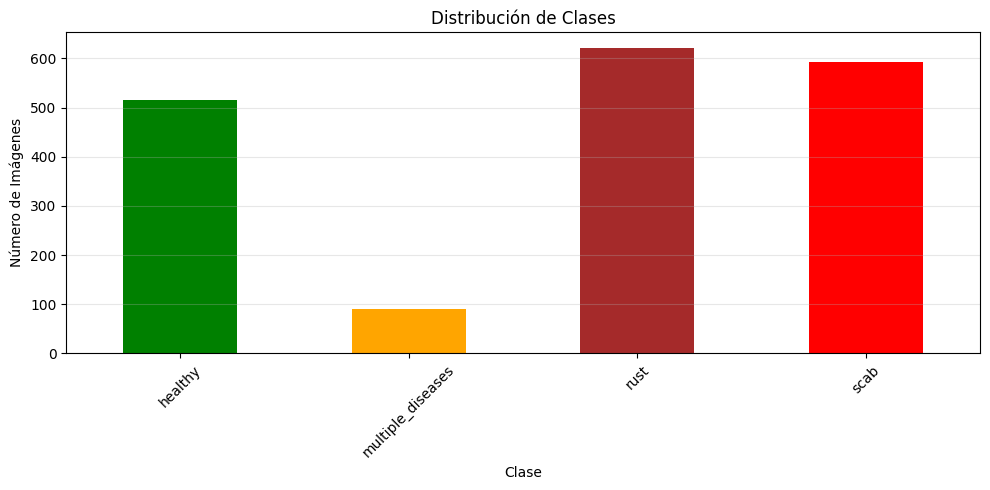

In [8]:
# Analizar distribución de clases
etiquetas = ['healthy', 'multiple_diseases', 'rust', 'scab']
conteo_clases = df[etiquetas].sum()

print("Distribución de clases:")
for etiqueta in etiquetas:
    conteo = conteo_clases[etiqueta]
    porcentaje = (conteo / len(df)) * 100
    print(f"  {etiqueta:20s}: {conteo:4d} ({porcentaje:5.2f}%)")

# Visualizar
plt.figure(figsize=(10, 5))
conteo_clases.plot(kind='bar', color=['green', 'orange', 'brown', 'red'])
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# Preparar etiquetas
y = df[etiquetas].values.astype(np.float32)
df['indice_clase'] = np.argmax(y, axis=1)

# División: 70% train+val, 30% test
df_train_val, df_test, y_train_val, y_test = train_test_split(
    df, y,
    test_size=0.30,
    random_state=SEMILLA,
    stratify=df['indice_clase'],
    shuffle=True)

# División de train_val: 80% train, 20% val
df_train, df_val, y_train, y_val = train_test_split(
    df_train_val, y_train_val,
    test_size=0.20,
    random_state=SEMILLA,
    stratify=df_train_val['indice_clase'],
    shuffle=True)

print("División de datos:")
print(f"  Train:      {len(df_train):4d} ({len(df_train)/len(df)*100:5.1f}%)")
print(f"  Validation: {len(df_val):4d} ({len(df_val)/len(df)*100:5.1f}%)")
print(f"  Test:       {len(df_test):4d} ({len(df_test)/len(df)*100:5.1f}%)")
print(f"  Total:      {len(df):4d}")

División de datos:
  Train:      1019 ( 56.0%)
  Validation:  255 ( 14.0%)
  Test:        547 ( 30.0%)
  Total:      1821


In [10]:
# Calcular pesos de clase para balanceo
pesos_clase = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['indice_clase']),
    y=df_train['indice_clase'])
    
diccionario_pesos_clase = {i: peso for i, peso in enumerate(pesos_clase)}

print("\nPesos de clase:")
for i, (etiqueta, peso) in enumerate(zip(etiquetas, pesos_clase)):
    print(f"  {etiqueta:20s}: {peso:.3f}")


Pesos de clase:
  healthy             : 0.881
  multiple_diseases   : 4.995
  rust                : 0.732
  scab                : 0.770
